# Projecting and Transforming Geometries

This notebook contains simple code in wich coordinate reference systems (CRS) and, projections and transformations are analyzed.

Look at the companion guide: [`README.md`](../README.md).

Table of contents:

- 3. Projecting and Transforming Geometries
  - 3.1 Coordinate Reference Systems
    - Example 1: Transform GeoDataFrame CRS
    - Example 2: Create a Point and Transform Its CRS
    - Example 3: Measure Distances between Points and Plot
  - 3.2 Spatial Operations: Creating New Geometries
    - Example 1: Plot Dataset
    - Example 2: Intersection
  - 3.3 Overlaying Spatial Datasets
    - Example 1: Intersection Overlay in San Sebastian
    - Example 2: Intersection Inspection

## 3. Projecting and Transforming Geometries

The most common way to express the location on a spot in the world are the **geographic coordinates**, which are expressed in:

- Longitude: `[-180, 180] deg`; related to `x`, starting at the Equator.
- Latitude: `[-90, 90] deg`; related to `y`, starting at the Greewich meridian.

The **geographic coordinates** are a **Coordinate Reference System** or **CRS**, because they set a frame in which we can define points. In practice, there are many CRS, depending on our application, and we apply **projections** to go from one to the other.

For instance, the geographic coordinates are not the best CRS to measure distances between points, thus we need to project the CRS to get `(x, y)` values. One possible projection or CRS is Mercator.

In [2]:
import pandas as pd
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt

In [3]:
DATA_PATH_PARIS = '../../data/work_geodata/Paris/'

### 3.1 Coordinate Reference Systems

We can get the CRS in which a geodataframe is expressed with `.crs`; some popular CRS are:

- `EPSG:4326` or `WGS84`: geographic coordinates, i.e., longitude & latitude.
- `EPSG:3857`: a very common projection, which has units in meters and is used in Google maps and most other apps.

To manipulate different geo-datasets, we need to make sure they're all in the same CRS. Additionally, note that:

- **All CRS projections introduce deformations. Each country/region has a best projection CRS for accurate distance computations**. See:
  - [https://spatialreference.org](https://spatialreference.org)
  - [https://epsg.io](https://epsg.io)
- Any distancce operation in geopandas/shapely expects points described on a cartesian plane. However, CRS manipulation is done only in geopandas, i.e., shapely objects work simply with cartesian floating point values.

#### Example 1: Transform GeoDataFrame CRS

In [4]:
districts = gpd.read_file(DATA_PATH_PARIS+'paris_districts_utm.geojson')

In [7]:
print(districts.crs)

epsg:32631


In [6]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


In [10]:
# We can convert a geodataframe to another CRS as follows
districts = districts.to_crs(epsg = 3857)

#### Example 2: Create a Point and Transform Its CRS

In [44]:
# Construct a Point object for the Eiffel Tower
from shapely.geometry import Point
eiffel_tower = Point(2.2945, 48.8584) # Logitude, Latitude

# Put the point in a GeoSeries with the correct CRS
s_eiffel_tower = gpd.GeoSeries([eiffel_tower], crs={'init': 'EPSG:4326'})

# Convert to other CRS
s_eiffel_tower_projected = s_eiffel_tower.to_crs(epsg=2154)

# Print the projected point
print(s_eiffel_tower_projected)

0    POINT (648237.302 6862271.682)
dtype: geometry


/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### Example 3: Measure Distances between Points and Plot

In [50]:
restaurants = pd.read_csv(DATA_PATH_PARIS+"paris_restaurants.csv")
restaurants = gpd.GeoDataFrame(restaurants,
                               geometry=gpd.points_from_xy(restaurants.x,
                                                           restaurants.y))

In [51]:
restaurants.geometry

0       POINT (259641.692 6251867.063)
1       POINT (259572.340 6252029.683)
2       POINT (259657.276 6252143.401)
3       POINT (259684.438 6252203.137)
4       POINT (259597.943 6252230.044)
                     ...              
5730    POINT (259415.268 6253553.831)
5731    POINT (259039.342 6253966.817)
5732    POINT (267737.068 6251037.256)
5733    POINT (267811.874 6250976.682)
5734    POINT (268032.955 6249938.191)
Name: geometry, Length: 5735, dtype: geometry

In [52]:
print(restaurants.crs)

None


In [53]:
# Restaurants are in the Web Mercator CRS
# Set it manually
restaurants.crs = {'init': 'epsg:3857'}

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [57]:
# Extract the single Point
eiffel_tower = s_eiffel_tower_projected[0]

# Ensure the restaurants use the same CRS
restaurants = restaurants.to_crs(crs=s_eiffel_tower_projected.crs) 

print(f"New CRS: {restaurants.crs}")

# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants.geometry.distance(eiffel_tower)

# The distance to the closest restaurant
print(dist_eiffel.min())

New CRS: epsg:2154
303.5625538786418


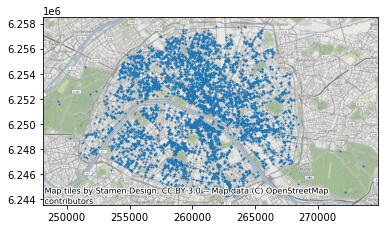

In [58]:
# Contextily requires the Web Mercator CRS
# Convert to the Web Mercator projection
restaurants_webmercator = restaurants.to_crs(epsg=3857)

# Plot the restaurants with a background map
ax = restaurants_webmercator.plot(markersize=1)
contextily.add_basemap(ax)
plt.show()

### 3.2 Spatial Operations: Creating New Geometries

We can perform spatial operations with the polygons in such a way that we get new polygons; such oprations are:

- `a.intersection.(b)`
- `a.union.(b)`
- `a.difference.(b)`

If we apply those operations between two `gpd` tables, we get a `GeoSeeries` with the same number of rows (but one column: `geometry`). Depending on the operation, these geometries can be: the same as before, different (result of the operation, e.g., intersection), or null/empty.

    gdf.intersection(box)

The next examples use a simplified version of Donstia-San Sebastian land use dataset based on the open [European Urban Atlas](https://land.copernicus.eu/local/urban-atlas).  Go to the web, log in, select map/atlas and city, and download it!


#### Example 1: Plot Dataset

In [116]:
DATA_PATH = "../../data/Donostia_Urban_Atlas/"

In [117]:
# Import the land use dataset: Donostia-San Sebastian
land_use = gpd.read_file(DATA_PATH+'Data/ES510L1_DONOSTIA_SAN_SEBASTIAN_UA2018_v013.gpkg')

In [69]:
land_use.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,geometry
0,ES,Donostia-San Sebastián,ES510L1,11100,Continuous urban fabric (S.L. : > 80%),2020-03,176-ES510L1,244.247867,2815.288645,NaN,121,"MULTIPOLYGON (((3352920.387 2322440.803, 33528..."
1,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2174-ES510L1,216.559756,2906.066983,NaN,0,"MULTIPOLYGON (((3359880.297 2316412.269, 33598..."
2,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2496-ES510L1,245.246742,3597.133588,NaN,0,"MULTIPOLYGON (((3359550.890 2317186.177, 33595..."
3,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2403-ES510L1,241.945303,3671.962466,NaN,10,"MULTIPOLYGON (((3352029.553 2318515.484, 33520..."
4,ES,Donostia-San Sebastián,ES510L1,12100,"Industrial, commercial, public, military and p...",2020-03,3206-ES510L1,322.561924,5087.592913,NaN,0,"MULTIPOLYGON (((3358443.760 2317973.059, 33584..."


In [70]:
land_use.shape

(5976, 12)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


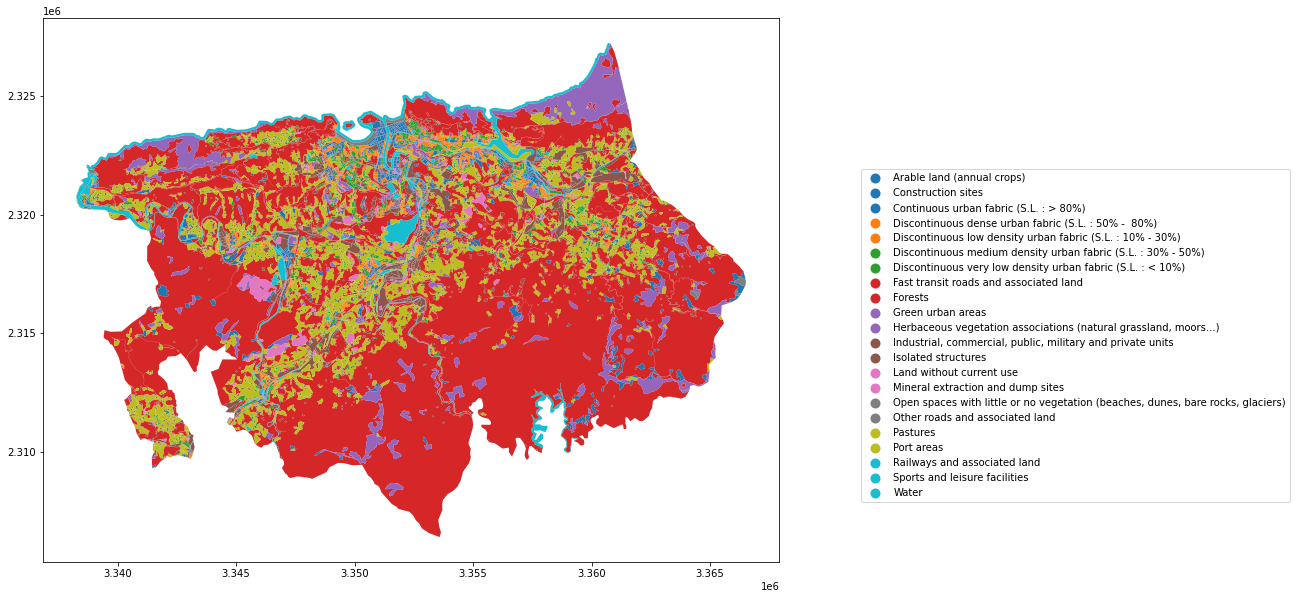

In [151]:
# Make a plot of the land use with 'class' as the color
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend
land_use.plot(column='class_2018',
              legend=True, 
              figsize=(15, 10),
              legend_kwds={'loc': 'lower right',
                           'bbox_to_anchor': (1.7, 0.1)})
plt.show()

In [66]:
# Add the area as a new column
land_use['area'] = land_use.geometry.area

In [68]:
# Calculate the total area for each land use class
total_area = land_use.groupby('class_2018')['area'].sum() / 1000**2
print(total_area.sort_values(ascending=False))

class_2018
Forests                                                                            195.821197
Pastures                                                                            48.119896
Herbaceous vegetation associations (natural grassland, moors...)                    20.452536
Industrial, commercial, public, military and private units                          15.029235
Other roads and associated land                                                      7.319181
Water                                                                                7.151335
Arable land (annual crops)                                                           5.302602
Isolated structures                                                                  4.727019
Discontinuous very low density urban fabric (S.L. : < 10%)                           4.672770
Discontinuous dense urban fabric (S.L. : 50% -  80%)                                 3.636626
Discontinuous medium density urban fabric (S.L. :

#### Example 2: Intersection

In [108]:
from shapely import Polygon
from shapely.geometry import box

# I have taken the coordinates which enclose the city center
# For more information on how to create Shapely objects
# https://shapely.readthedocs.io/en/stable/manual.html
center_polygon = box(minx=3347000, miny=2322000, maxx=3357000, maxy=2325000, ccw=True)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

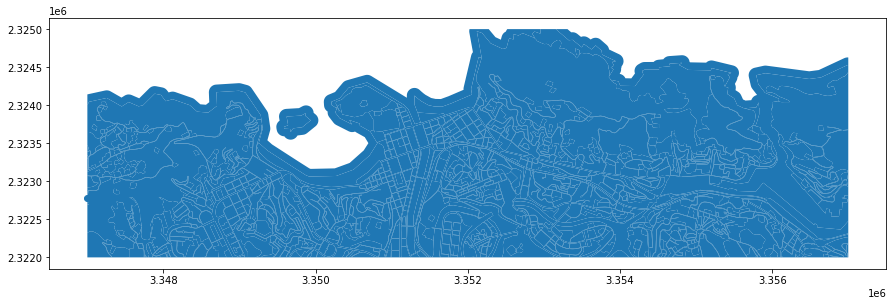

In [109]:
# Note that we pass a Shapely object to the geodataframe
land_use_intersection = land_use.intersection(center_polygon)
land_use_intersection.plot(figsize=(15,10))

In [113]:
# Note that the intersected object is a GeoSeries
# which has the same number of rows as the original gdf
# BUT one column (geometry), and additionally,
# some rows have NaN/Null value, i.e., those which do not overlap!
# The new geometries can be: same as before, intersected, or empty.
# In order to get their attributes we need to perform a join/concat.
type(land_use_intersection)

geopandas.geoseries.GeoSeries

In [114]:
land_use_intersection.shape

(5976,)

In [115]:
land_use.shape

(5976, 12)

### 3.3 Overlaying Spatial Datasets

The `gdf.intersection(geom)` operation is limited because 

- we can instersct a `gdf` with a single polygon/geometry;
- we get a `GeoSeries` without attributes, just geometries, i.e., we don't preserve the attributes.

A more sophisticated alternative to `intersection` is `overlay`. When we perform this operation:

- we use a `gdf` and overlay to it another `gdf`, not just a polygon/geometry;
- we get `gdf` back with attributes and with all possible combinations of intersected geometries.

Example: we have two `gdf`s, (1) European countries and (2) geological regions; when we apply

```python
gpd.overlay(countries, geological_regions, how='intersection')
```

we get more geometries than countries or geological regions (i.e., all possible intersection combinations), each with their attributes.

#### Example 1: Intersection Overlay in San Sebastian

In [118]:
# Import the districts dataset
# https://www.donostia.eus/datosabiertos/dataset/mapa_auzoak/resource/1ae83785-b6ac-466f-9548-0834143967fc?view_id=4eea417c-3f47-407d-bb7d-c7e1cfaeec2b
districts = gpd.read_file(DATA_PATH+'donostia_auzoak.json')

In [134]:
districts.head()

,KodAuzo,IzenAuzo,name,geometry
0,18,LANDERBASO,LANDERBASO,"POLYGON ((3356935.505 2316428.554, 3356934.817..."
1,11,IGELDO,IGELDO,"POLYGON ((3348456.570 2323932.694, 3348456.422..."
2,10,IBAETA,IBAETA,"POLYGON ((3346924.316 2321073.379, 3346925.976..."
3,5,AÑORGA,AÑORGA,"POLYGON ((3349982.745 2320999.298, 3349887.524..."
4,4,ANTIGUA,ANTIGUA,"POLYGON ((3349791.685 2323131.469, 3349791.737..."


In [135]:
districts['name'].unique()

array(['LANDERBASO', 'IGELDO', 'IBAETA', 'AÑORGA', 'ANTIGUA', 'AIETE',
       'ERDIALDEA', 'MIRAMON - ZORROAGA', 'AMARABERRI', 'GROS', 'EGIA',
       'ATEGORRIETA - ULIA', 'LOIOLA', 'MARTUTENE', 'INTXAURRONDO',
       'MIRAKRUZ - BIDEBIETA', 'ALTZA', 'ZUBIETA', 'OARAIN'], dtype=object)

In [130]:
districts.shape

(20, 4)

In [131]:
land_use.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,geometry
0,ES,Donostia-San Sebastián,ES510L1,11100,Continuous urban fabric (S.L. : > 80%),2020-03,176-ES510L1,244.247867,2815.288645,NaN,121,"MULTIPOLYGON (((3352920.387 2322440.803, 33528..."
1,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2174-ES510L1,216.559756,2906.066983,NaN,0,"MULTIPOLYGON (((3359880.297 2316412.269, 33598..."
2,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2496-ES510L1,245.246742,3597.133588,NaN,0,"MULTIPOLYGON (((3359550.890 2317186.177, 33595..."
3,ES,Donostia-San Sebastián,ES510L1,11300,Isolated structures,2020-03,2403-ES510L1,241.945303,3671.962466,NaN,10,"MULTIPOLYGON (((3352029.553 2318515.484, 33520..."
4,ES,Donostia-San Sebastián,ES510L1,12100,"Industrial, commercial, public, military and p...",2020-03,3206-ES510L1,322.561924,5087.592913,NaN,0,"MULTIPOLYGON (((3358443.760 2317973.059, 33584..."


In [132]:
land_use.shape

(5976, 12)

In [123]:
# Transform to the same CRS
districts = districts.to_crs(crs=land_use.crs) 

In [125]:
# Overlay both datasets based on the intersection
combined = gpd.overlay(land_use, districts, how='intersection')

In [136]:
combined.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,KodAuzo,IzenAuzo,name,geometry
0,ES,Donostia-San Sebastián,ES510L1,11100,Continuous urban fabric (S.L. : > 80%),2020-03,176-ES510L1,244.247867,2.815289e+03,NaN,121,12,INTXAURRONDO,INTXAURRONDO,"POLYGON ((3352830.002 2322430.776, 3352825.692..."
1,ES,Donostia-San Sebastián,ES510L1,12220,Other roads and associated land,2020-03,3957-ES510L1,896419.044563,4.001143e+06,NaN,0,12,INTXAURRONDO,INTXAURRONDO,"MULTIPOLYGON (((3353966.387 2322737.210, 33539..."
2,ES,Donostia-San Sebastián,ES510L1,12220,Other roads and associated land,2020-03,3959-ES510L1,634424.207354,2.666334e+06,NaN,0,12,INTXAURRONDO,INTXAURRONDO,"POLYGON ((3353712.404 2321506.973, 3353712.671..."
3,ES,Donostia-San Sebastián,ES510L1,23000,Pastures,2020-03,5181-ES510L1,4524.050223,2.187186e+05,NaN,55,12,INTXAURRONDO,INTXAURRONDO,"POLYGON ((3353158.308 2321895.979, 3353149.398..."
4,ES,Donostia-San Sebastián,ES510L1,31000,Forests,2020-03,5484-ES510L1,5462.662767,3.901601e+05,NaN,0,12,INTXAURRONDO,INTXAURRONDO,"POLYGON ((3353166.888 2321882.603, 3353168.737..."


In [133]:
combined.shape

(2243, 15)

#### Example 2: Intersection Inspection

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


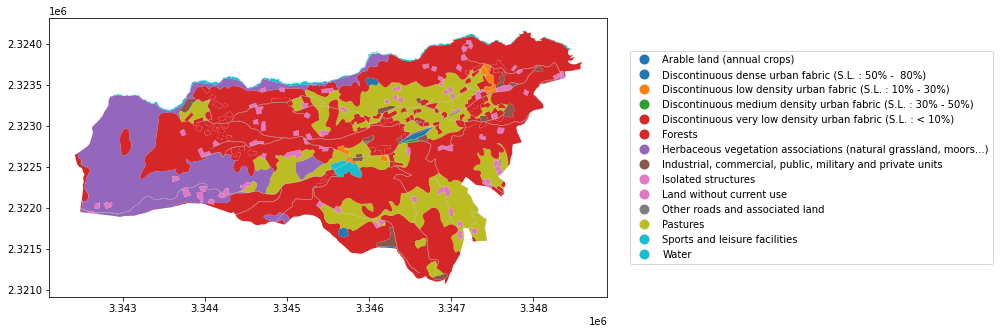

class_2018
Arable land (annual crops)                                          0.025501
Discontinuous dense urban fabric (S.L. : 50% -  80%)                0.016367
Discontinuous low density urban fabric (S.L. : 10% - 30%)           0.050546
Discontinuous medium density urban fabric (S.L. : 30% - 50%)        0.003498
Discontinuous very low density urban fabric (S.L. : < 10%)          0.370610
Forests                                                             5.100528
Herbaceous vegetation associations (natural grassland, moors...)    1.850564
Industrial, commercial, public, military and private units          0.128778
Isolated structures                                                 0.319578
Land without current use                                            0.024283
Other roads and associated land                                     0.216583
Pastures                                                            1.924819
Sports and leisure facilities                                    

In [150]:
# Add the area as a column
combined['area'] = combined.geometry.area

# Take a subset for the one district
land_use_district = combined[combined.name == "IGELDO"]

# Visualize the land use of the selected district
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend
land_use_district.plot(column = 'class_2018', 
                       figsize=(10,10),
                       legend=True,
                       legend_kwds={'loc': 'lower right',
                                   'bbox_to_anchor': (1.7, 0.1)})
plt.show()

# Calculate the total area for each land use class
print(land_use_district.groupby('class_2018')['area'].sum() / 1000**2)